In [53]:
import numpy as np
import pydicom as dicom
import os
from stl import mesh
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import cv2

In [54]:
def AddImage(path):
  ds = dicom.dcmread(path)

  image = ds.pixel_array
  # Convert to int16 (from sometimes int16), 
  # should be possible as values should always be low enough (<32k)
  image = image.astype(np.int16)
  image[image == -2000] = 0
  
  # Convert to Hounsfield units (HU)
  intercept = ds.RescaleIntercept
  slope = ds.RescaleSlope
  
  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)
      
  image += np.int16(intercept)
  image =  np.array(image, dtype=np.int16)
  return image

In [55]:
def AddImageToArray(x,folderPath):
  patchs = os.listdir(folderPath)
  for filename in sorted(patchs, key=len):
    f = os.path.join(folderPath, filename)
    if os.path.isfile(f):
      x.append(AddImage(os.path.join(folderPath, filename)))
    else:
      AddImageToArray(x,f)

In [56]:
x = []

AddImageToArray(x,'DICOM/PA2/ST1/SE4')

x = np.array(x)

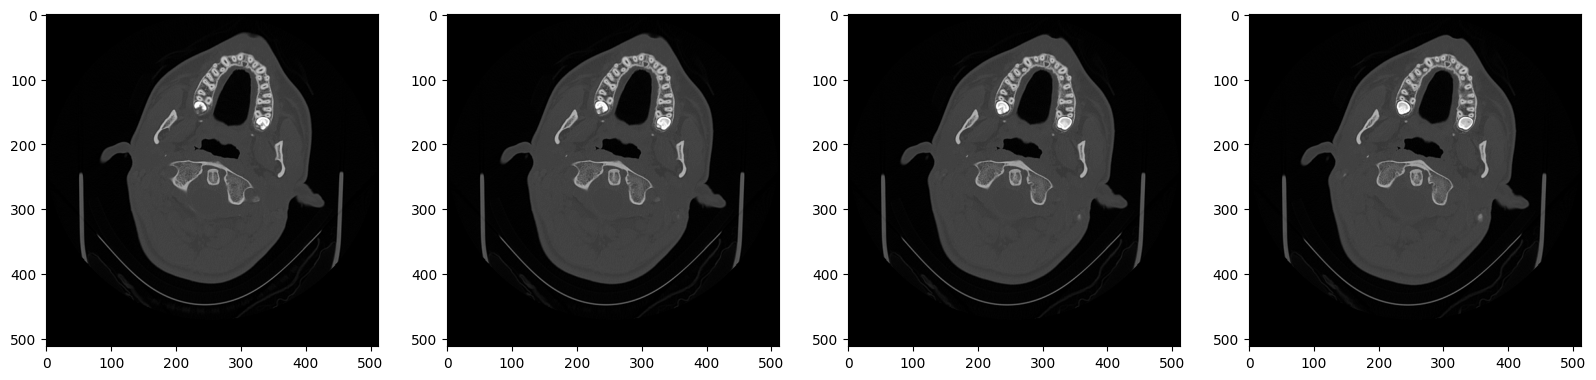

In [57]:
k = 0
plt.figure(figsize=(25,25))
for i in range(4):
  plt.subplot(5,5, i+1)
  plt.imshow(x[k], cmap='gray')
  k+=1

plt.show()

In [58]:
kernel_gauss = np.array([[1,2,1], [2,4,2], [1,2,1]])/9
img_gauss = cv2.filter2D(x, -1, kernel_gauss)

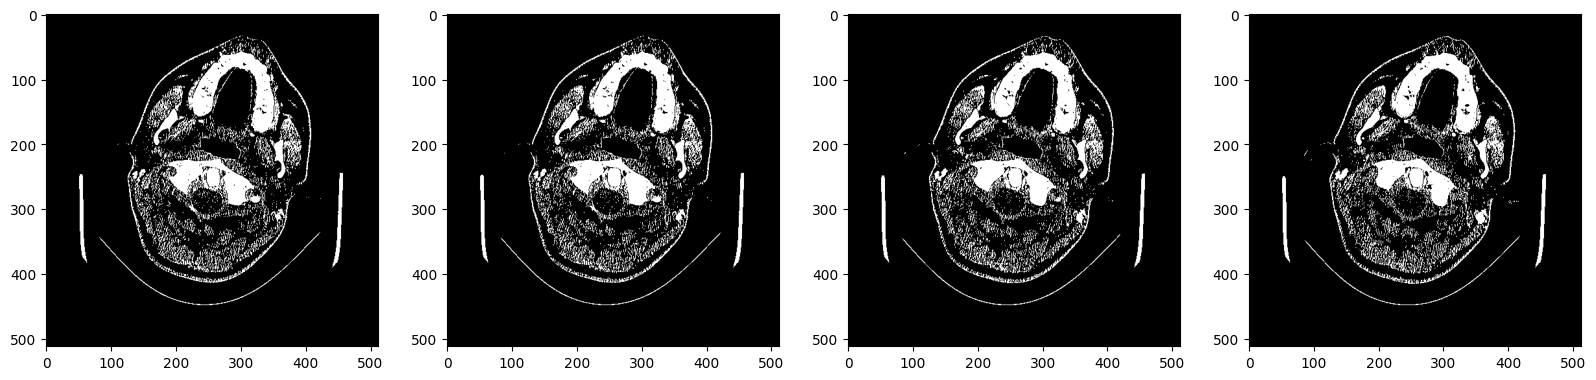

In [59]:
k = 0
plt.figure(figsize=(25,25))
for i in range(4):
  plt.subplot(5,5, i+1)
  plt.imshow(np.where(img_gauss[k] > 100, 1, 0), cmap='gray')
  k+=1

plt.show()

In [60]:
def make_mesh(image, threshold=-300, step_size=1):
    p = image.transpose(2,1,0)
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plt_3d(verts, faces):
    #verts[:,2] = verts[:,2] * 4
    cube = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            cube.vectors[i][j] = verts[f[j],:]
    
    cube.save('skull.stl')

In [64]:
print(img_gauss[0].max())

5460


In [65]:
v, f = make_mesh(img_gauss, 1000,1)
plt_3d(v, f)